In [19]:
#Code for importing packages
import pandas as pd  
import warnings
warnings.filterwarnings("ignore")  
import numpy as np 
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,auc 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import classification_report

In [4]:
df = pd.read_csv('data_all_dummies-Copy1.csv')
del df['Unnamed: 0'] 
df.head()

,age,height,job_catagories,female,male,heterosexual,not_heterosexual,body_average,body_curvy/full_figured,body_fit/athletic,...,cancer,capricorn,gemini,leo,libra,pisces,sagittarius,scorpio,taurus,virgo
0,22,75.0,public_services,0,1,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,35,70.0,public_services,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,29,66.0,entertainment/artist/craftmans,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,29,67.0,science/tech,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,31,65.0,entertainment/artist/craftmans,1,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [5]:
df.job_catagories.value_counts()

public_services                   9598
other_white_collar                8296
science/tech                      7442
entertainment/artist/craftmans    6808
Name: job_catagories, dtype: int64

In [6]:
#Feature Selection
all_features = df.drop(["job_catagories"],axis=1) 
target_feature = df["job_catagories"]
all_features.head()

,age,height,female,male,heterosexual,not_heterosexual,body_average,body_curvy/full_figured,body_fit/athletic,body_thin/skinny,...,cancer,capricorn,gemini,leo,libra,pisces,sagittarius,scorpio,taurus,virgo
0,22,75.0,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,35,70.0,0,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,29,66.0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,29,67.0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,31,65.0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [7]:
#Normalizing values
from sklearn import preprocessing
x = all_features.values.astype(float) #returns a numpy array of type float
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
scaled_features = pd.DataFrame(x_scaled)

In [8]:
#Preprocessing dataset for algorithm
Y=list()
X=np.array(scaled_features)
y=np.array(target_feature)
label_dict = {'public_services':0, 'other_white_collar':1, 'science/tech':2, 'entertainment/artist/craftmans':3 }
_label_dict = {0 :'public_services' , 1 :'other_white_collar' , 2 :'science/tech', 3: 'entertainment/artist/craftmans'}
for i in y:
    Y.append(label_dict[i])
y=np.array(Y,dtype=int)
y_unique = np.unique(y) 

In [9]:
#Modelling logistic regression
def logisticRegression(X, y,theta,num_iter):
    
    #Sigmoid function
    def sigmoid(z):
        return 1.0 / (1 + np.exp(-z))
    
    #Cost function
    def costFunc(theta, X, y, lr = 0.001):
        h = sigmoid(X.dot(theta))
        r = (lr/(2 * len(y))) * np.sum(theta**2)
        return (1 / len(y)) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h))) + r
    
    #Gradient descent function
    def gradientFunc(theta, X, y, lr = 0.001):
        m, n = X.shape
        theta = theta.reshape((n, 1))
        y = y.reshape((m, 1))
        h = sigmoid(X.dot(theta))
        r = lr * theta /m
        return ((1 / m) * X.T.dot(h - y)) + r
    
    #Finding best theta
    for i in range(num_iter):
        lineq = np.dot(X, theta)
        h = sigmoid(lineq)
        #Calculating cost function of each class
        cost = costFunc(theta, X,y) 
        cost = cost.sum(axis = 0)
        #Applying gradient descent to find new theta
        delta = gradientFunc(theta,X,y) 
        theta = theta - delta    
    return theta 

In [10]:
#Sigmoid function
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

In [53]:
#Model training
score = list()
missclass =0 

#KFold cross validation
for fold in range(5):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
    #OneVsRest
    i,k,n= 0,4,61 #No of classes and features
    all_theta = np.zeros((k, n))
    for obs in y_unique:
        np_y_train = np.array(y_train == obs, dtype = int)
        best_theta = logisticRegression(X_train, np_y_train, np.zeros((n,1)),10000)
        all_theta[i] = best_theta.T
        i += 1   
    #Predictions
    prediction = sigmoid(X_test.dot(all_theta.T))
    prediction = prediction.tolist()
    pred = list()
    act = list()
    for _i,i in enumerate(prediction):
        pred.append(_label_dict[ i.index(max(i)) ])
        if _label_dict[ i.index(max(i)) ] !=  _label_dict[y_test[_i]] :
            missclass += 1
        act.append(_label_dict[y_test[_i]]) 
    score.append(round(accuracy_score(pred, act)*100,2))
    print("The score for Logistic Regression for fold",fold+1,"is: ",score[fold] ,'%', " No of misclassfied",missclass)
print("The overall score for Logistic Regression is: ", round(sum(score)/len(score),2),'%')

The score for Logistic Regression for fold 1 is:  38.02 %  No of misclassfied 3985
The score for Logistic Regression for fold 2 is:  38.22 %  No of misclassfied 7957
The score for Logistic Regression for fold 3 is:  40.38 %  No of misclassfied 11790
The score for Logistic Regression for fold 4 is:  39.0 %  No of misclassfied 15712
The score for Logistic Regression for fold 5 is:  39.07 %  No of misclassfied 19629
The overall score for Logistic Regression is:  38.94 %


In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
#define classification model
Multiclass_model = LogisticRegression(multi_class='ovr')
#fit model
Multiclass_model.fit(X_train, y_train)
#make final predictions
y_hat_test = Multiclass_model.predict(X_test)
y_hat_train = Multiclass_model.predict(X_train)

In [15]:
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    10263
1     8585
2     4128
3     2739
dtype: int64
0    0.399106
1    0.333852
2    0.160529
3    0.106514
dtype: float64


In [16]:
residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    2541
1    2162
2    1086
3     640
dtype: int64
0    0.395240
1    0.336289
2    0.168922
3    0.099549
dtype: float64


In [17]:
# Print confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[975 351 357 203]
 [641 470 414 178]
 [332 247 727 189]
 [437 219 320 369]]


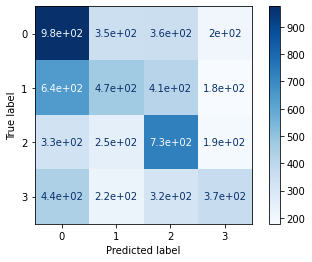

In [18]:
# Visualize your confusion matrix
plot_confusion_matrix(Multiclass_model, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

In [36]:
from sklearn.metrics import precision_score
precision_score(y_train, y_hat_train, average='micro')

0.3974722924363212

In [37]:
precision_score(y_train, y_hat_train, average='weighted')

0.39115125508764376

In [39]:
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.42      0.54      0.47      7680
           1       0.35      0.25      0.29      6620
           2       0.41      0.51      0.45      5954
           3       0.38      0.26      0.31      5461

    accuracy                           0.40     25715
   macro avg       0.39      0.39      0.38     25715
weighted avg       0.39      0.40      0.39     25715

